In [63]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [64]:
import matplotlib.pyplot as plt
import lumicks.pylake as lk
import itertools
import ipywidgets
import numpy as np
import glob
import os
import shutil
# We use skimage to downsample the data
from skimage.measure import block_reduce
from statistics import mean
from statistics import median
from scipy.stats import sem
from matplotlib_venn import venn2 #this line is used for making venn diagrams of interactions
%matplotlib inline
# Use notebook if you're in Jupyter Notebook
%matplotlib notebook

In [65]:
filename = glob.glob('*.h5') #fetches filename assuming only one .h5 in notebook
if len(filename) == 1:
    print (filename[0])
else: 
    print ("too many or too few .h5 files")

20230217-142430 Kymograph sv40-4x-5.h5


In [66]:
plt.close('all')#This closes any plots left open to save memory and loads up the .h5 file in folder
file = lk.File(str(filename[0]))
_, kymo = file.kymos.popitem()

In [67]:
forcex = file["Force HF"]["Force 1x"] #this cell downsamples the force to save memory and make it easier to visualize

# time traces (seconds)
time = forcex.timestamps/1e9
time = time - time[0]
sample_rate = forcex.sample_rate

downsampled_rate = 50 # Hz, this rate can be changed as needed

# downsample the force, nanostage position and time
forcex_downsamp = forcex.downsampled_by(int(sample_rate/downsampled_rate))
time_downsamp = forcex_downsamp.timestamps/1e9
time_downsamp = time_downsamp - time_downsamp[0]

median_force = (median(forcex_downsamp.data))


In [68]:

from kymowidget import KymoWidgetGreedy #imports the widget for kymograph analysis

In [69]:
_, kymo = file.kymos.popitem() #after defining the downsample rate earlier, this actually does the downsampling

data = kymo.blue_image #note this depends on the collection channel -- for Cy3 we use green
downsample_factor = 1
data = block_reduce(data, (1, downsample_factor))
rgb = kymo.rgb_image

In [70]:
dt = downsample_factor * kymo.line_time_seconds

<IPython.core.display.Javascript object>


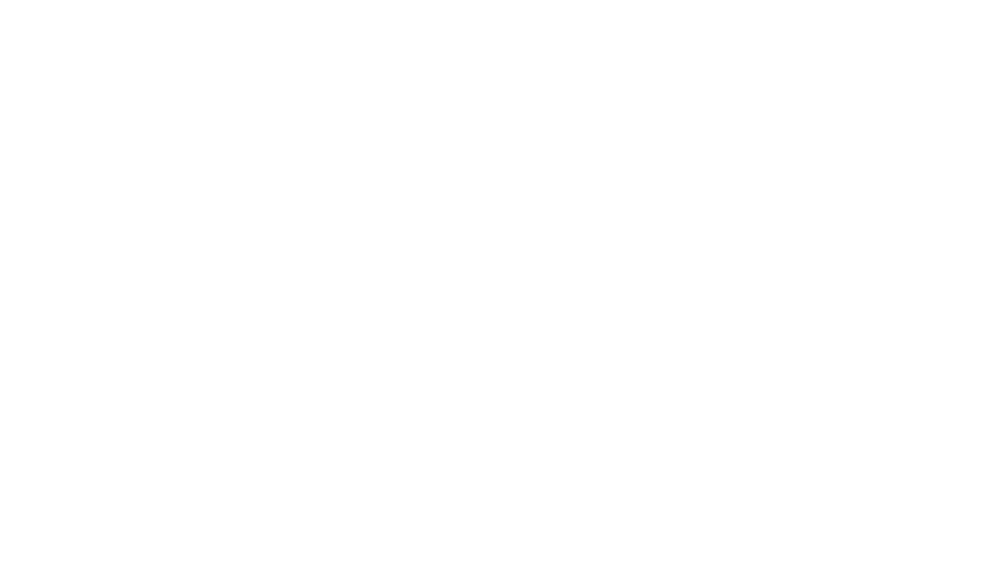

In [71]:
plt.figure(figsize=(7, 4)) #this plots the kymograph side-by-side with the force

# Plot the kymograph
ax1 = plt.subplot(2, 1, 1)
plt.title('UV-DDB binding UV-damaged lambda DNA')
# We use aspect="auto" because otherwise the kymo would be very long and thin
kymo.plot_blue(vmax=3, aspect="auto")


# Plot the force
ax2 = plt.subplot(2, 1, 2, sharex = ax1)
forcex_downsamp.plot(color='blue')
plt.ylabel('Force (pN)')
plt.tight_layout()
plt.title('DNA tension')
ax2.set_facecolor('gray')
plt.show()

In [72]:
pixel_size = kymo.pixelsize_um
pixel_size_int = pixel_size[0]

In [73]:
print(pixel_size_int)

0.05


In [74]:
kw = KymoWidgetGreedy(data, axis_aspect_ratio=2, min_length=4, pixel_threshold=5, window=7, sigma=1, vmax=2)
#this first plot is to look at the kymograph on the pixel scale in order to decide if an upper and lower bound need to be applied

In [75]:
#Trim the data to avoid the beads by defining upper and lower bounds
lower_bound= 0
adjusted_lower_bound = pixel_size_int * lower_bound
upper_bound= 300
adjusted_upper_bound = pixel_size_int * upper_bound
data = data[lower_bound:upper_bound, 0:2500] 
steps_between_bounds = int((adjusted_upper_bound - adjusted_lower_bound) * 10) #defines number of 100 nm steps between bounds
kymo.blue_data = kymo.blue_image[lower_bound:upper_bound, 0:2500]
plt.close('all')

<IPython.core.display.Javascript object>


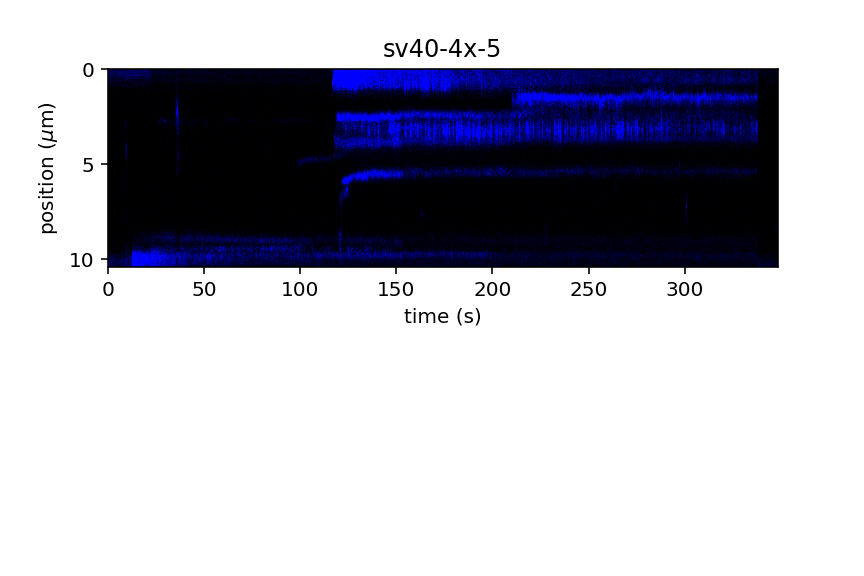

In [76]:
# Plot the kymograph
ax1 = plt.subplot(2, 1, 1)
plt.title('UV-DDB binding UV-damaged lambda DNA')
# We use aspect="auto" because otherwise the kymo would be very long and thin
kymo.plot_blue(vmax=5, aspect="auto")

#This cell for tracking lines with kymowidget greedy. It opens two views -- one with a fixed aspect ratio and one adjustable
#By saving and loading the lines as bluekymotracks.txt, they can easily be swapped back and forth between views as needed.
blue_lines = KymoWidgetGreedy(kymo.blue_data, aspect="auto", line_width=8, min_length=20, pixel_threshold=1, window=15, sigma=1, vmax=5)
blue_lines = KymoWidgetGreedy(kymo.blue_data, axis_aspect_ratio=2, line_width=8, min_length=8, pixel_threshold=1, window=15, sigma=1, vmax=2)

In [78]:
blue_lines.save_lines("kymotracks.txt", dt=dt, dx=pixel_size, sampling_width=3)